In [ ]:
Блок:Разведывательный анализ данных 
Контрольная работа: EDA-5 А/В тестирование
Группа: DSPR - 73
Выполнил: Новиков Павел Викторович


## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [349]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [350]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [351]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Ответ: Столбец date имеет тип данных object

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [352]:
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')

In [353]:
data_group_min = data.groupby(['group'])['date'].min()
data_group_max = data.groupby(['group'])['date'].max()
print(data_group_min)
print(data_group_max)

group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]
group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]


Ответ: А/В тест проводился в период со 2 по 24 января 2021 в обоих группах.

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [354]:
visit_count = data.groupby(['group'])['user_id'].count()
print(visit_count)

purchase_count = data.groupby(['group'])['purchase'].sum()
print(purchase_count)

price_count = data.groupby(['group'])['price'].sum()
print(price_count/1000000)


group
A    147202
B    147276
Name: user_id, dtype: int64
group
A    17723
B    17514
Name: purchase, dtype: int64
group
A    1436.26
B    1554.10
Name: price, dtype: float64


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [355]:
mask = data['group'] == 'A'
set_a = set(data[mask]['user_id'])
mask1 = data['group'] == 'B'
set_b = set(data[mask1]['user_id'])
set_intersection = set_a.intersection(set_b)
print(len(set_intersection), len(set_a), len(set_b))


1895 146195 146284


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [356]:
updated_data = data[data['user_id'].apply(lambda x: x not in set_intersection)]

In [357]:
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Где set_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

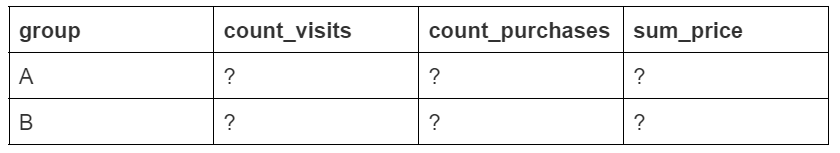
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [358]:
group_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits','purchase':'count_purchases','price':'sum_price'})
print(group_data)

  group  count_visits  count_purchases   sum_price
0     A        145307            17487  1417780000
1     B        145381            17290  1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Ответ: Количество посещений обоих вариантов сопоставимо, т.к. отличается на несколько тысячных долей процента. 00,05%(145387-145307)/145381*100 
О сбалансированности выборок ничего сказать нельзя, т.к. я не знаю как проводилась настройка распределения на группы.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [359]:
group_data['conversion'] = round((group_data['count_purchases']/group_data['count_visits']*100),2)
group_data['mean_check'] = round(group_data['sum_price']/group_data['count_purchases'])

In [360]:
group_data.head()

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Ответ: Вариант А более эффективен по абсолютному показателю суммарного количества покупок count_purchases и по относительному показателю коонверсии покупки conversion.
Вариант В более эффективен  вабсолюных цифрах по общему количеству посещений сайта count_visits и по сумме покупок sum_price, а также по относительному показателю среднего чека mean_check

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [361]:
table = pd.pivot_table(updated_data, values='purchase', index='group', columns='price', aggfunc=np.sum)

In [362]:
print(table)

price  0       10000   60000   100000  150000  200000
group                                                
A           0    5182    5271    1832    3478    1724
B           0    5201    1730    5227    3438    1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot:xlabel='price', ylabel='group'>

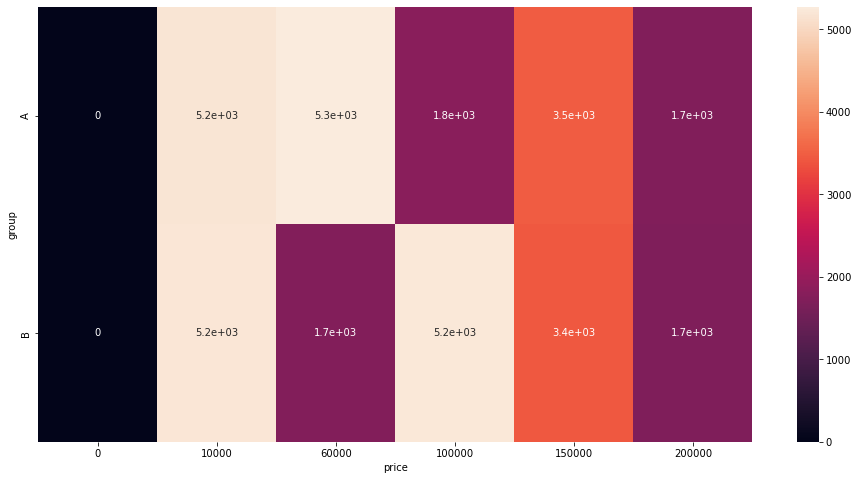

In [363]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(16, 8))
sns.heatmap(table, annot=True, ax=ax1)

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Ответ: Исходя из построенной таблицы видно, что популярность туров стоимостью 10000, 150000, 200000 руб. в целом одинакова в обоих группах, они окрашены одинаково. 
Имеются различия в популярности туров стоимостью 60000 и 100000 руб. первый более популярен в группе А, а второй в группе В.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [364]:
updated_data = updated_data.groupby(['group','date'], as_index=False).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).rename(columns={'user_id': 'count_visits','purchase':'count_purchases','price':'sum_price'})
updated_data['day_conv'] = updated_data['count_purchases']/updated_data['count_visits']
updated_data['day_mean_check'] = updated_data['sum_price']/updated_data['count_purchases']
updated_data.head()

,group,date,count_visits,count_purchases,sum_price,day_conv,day_mean_check
0,A,2021-01-02,2854,359,29410000,0.125788,81922.005571
1,A,2021-01-03,6596,748,62000000,0.113402,82887.700535
2,A,2021-01-04,6566,799,64250000,0.121687,80413.016270
3,A,2021-01-05,6433,790,64550000,0.122804,81708.860759
4,A,2021-01-06,6606,764,63410000,0.115652,82997.382199


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [365]:
# вычисляем кумулятивное количество посещений страницы
updated_data['cum_users_count'] = updated_data.groupby(['group'])['count_visits'].cumsum()
# вычисляем кумулятивное количество покупок
updated_data['cum_purchase_count'] = updated_data.groupby(['group'])['count_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок
updated_data['cum_price_count'] = updated_data.groupby(['group'])['sum_price'].cumsum()
display(updated_data.head())

,group,date,count_visits,count_purchases,sum_price,day_conv,day_mean_check,cum_users_count,cum_purchase_count,cum_price_count
0,A,2021-01-02,2854,359,29410000,0.125788,81922.005571,2854,359,29410000
1,A,2021-01-03,6596,748,62000000,0.113402,82887.700535,9450,1107,91410000
2,A,2021-01-04,6566,799,64250000,0.121687,80413.016270,16016,1906,155660000
3,A,2021-01-05,6433,790,64550000,0.122804,81708.860759,22449,2696,220210000
4,A,2021-01-06,6606,764,63410000,0.115652,82997.382199,29055,3460,283620000


In [366]:
#считаем кумулятивную конверсию 
updated_data['cum_conv'] = updated_data['cum_purchase_count']/updated_data['cum_users_count']*100
#считаем кумулятивный средний чек
updated_data['cum_mean_check'] = updated_data['cum_price_count']/updated_data['cum_purchase_count']


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

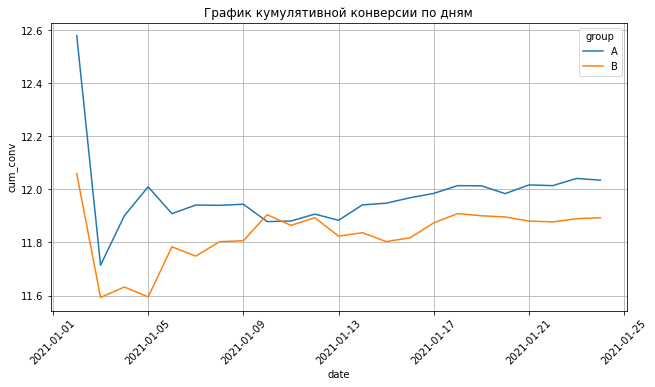

In [392]:

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conv', data=updated_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

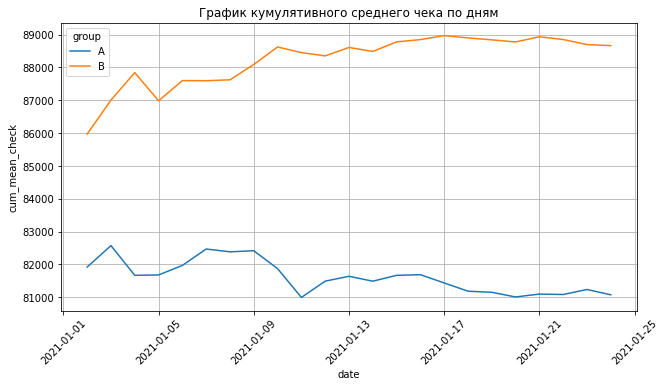

In [393]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=updated_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Ответ: А/В тест можно считать завершенным, т.к.  на графиках прекращатились резкие пики и спады показателей, и линии постепенно выравнивнялись в горизонтальную прямую. Кумулятивная конверсия в конце исследования выше в группе А, а показатель кумулятивного среднего чека выше в группе В. 

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

Ответ: Для проверки гипотезы о равенстве конверсий в группах применим Z-тест для пропорций. Т.к.выборка более 30 элементов, типы переменных количественные и сравниваются 2 группы показателей.

In [370]:
#импортируем библиотеку для z-теста
from statsmodels.stats.proportion import proportions_ztest

In [371]:
# Итак, сгруппируем данные по признаку группы и рассчитаем количество «успехов» 
# (сумма по столбцу converted) и общее количество наблюдений 
# (количество непустых значений в столбце converted) для каждой группы.


converted_piv= data.groupby('group', as_index = False)['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)


,sum,count
group,,
A,17723,147202
B,17514,147276


In [372]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value:  0.11
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Ответ: По результатам проведенного теста статистической разницы между конверсиями в группах А и В нет.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [373]:
from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое

In [374]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

In [377]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [378]:
conf_interval_a = proportions_conf_interval(
n=a_data['count_visits'].sum(), # размер выборки
x_p=a_data['day_conv'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['count_visits'].sum(), # размер выборки
x_p=b_data['day_conv'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.88, 12.21)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [379]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [380]:
# размеры выборок групп А и B
n = [a_data['count_visits'].sum(), b_data['count_visits'].sum()]
# выборочная пропорция групп A и B
xp = [a_data['day_conv'].mean(), b_data['day_conv'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Ответ: Между доверительными интервалами для групп А и В есть есть перекрытие. То есть мы не можем однозначно сказать, есть ли статистическая разница в конверсиях. Поэтому строим доверительный интервал разницы конверсий.
Левая граница доверительного интервала отрицательная, а правая — положительная. То есть истинная разница в конверсии может быть как положительной, так и отрицательной. 
Тогда это будет значить, что варианты А и B равнозначны по метрике конверсии. Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.39 % до 0.08 %. 
То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем — интервал охватывает точку 0.
Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

Ответ: Для проверки распределения на нормальность мы воспользуемся тестом Шапиро-Уилка 
Нулевая и альтернативные гипотезы:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'


In [381]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(updated_data[updated_data['group'] == 'A']['day_mean_check'])
shapiro_result_b = shapiro(updated_data[updated_data['group'] == 'B']['day_mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах? 
Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

Ответ: Для проверки гипотезы о равенстве средних чеков по дням в группах применим Т-тест.

In [382]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=updated_data[updated_data['group'] == 'A']['day_mean_check'],
    b=updated_data[updated_data['group'] == 'B']['day_mean_check'], 
    alternative='less' #Левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' 
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Ответ: Исходя из проведенного статистического Т-теста есть статистически значимая разница между ежедневными средними чеками в группах А и B.
Ежедневный средний чек в группе А меньше, чем в группе B

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [383]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

In [384]:
n_a = a_data['count_visits'].count() # размер выборки
k = n_a - 1 # число степеней свободы
x_mean_a = a_data['day_mean_check'].mean() # выборочное среднее
x_std_a = a_data['day_mean_check'].describe()['std'] # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [387]:
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std_a/(n_a ** 0.5) # погрешность
lower_bound = x_mean_a - eps # левая (нижняя) граница
upper_bound = x_mean_a + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал A: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал A: (79630, 82308)


In [389]:
n_b = b_data['count_visits'].count() # размер выборки
k = n_b - 1 # число степеней свободы
x_mean_b = b_data['day_mean_check'].mean() # выборочное среднее
x_std_b = b_data['day_mean_check'].describe()['std'] # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [390]:
t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std_b/(n_b ** 0.5) # погрешность
lower_bound = x_mean_b - eps # левая (нижняя) граница
upper_bound = x_mean_b + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал B: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Ответ: Между доверительными интервалами для групп А и В нет пересечения.
Отсюда можно сделать вывод, что существует статистическая разница в ежедневном среднем чеке между вариантами А и В.


## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Ответ: По метрике среднего чека можно сделать вывод, что вариант дизайна посадочной страницы 'B' более предпочтительный, т.к. существует статистически значимая разница в данном показателе между вариантом А и В.  
По метрике конверсии вывода о предпочтительности того или иного дизайна сделать нельзя, т.к. не существует статистически значимой разницы между вариантами А и В.
